In [14]:
import os
import vtk
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import time
import concurrent
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from importlib import reload
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams['svg.fonttype'] = 'none'
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage, writers
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter

from cell_shape_variation.steps.shapemode import avgshape
from cell_shape_variation.steps.analysis import analysis_tools as atools
from nuclear_shape_analysis_workflow.steps.make_feature_figures import make_feature_figures_utils as figtools

In [2]:
out = '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/local_staging/notebooks/fig_shapespace'

In [3]:
staging_folder = 'local_staging'

path_to_csv = f'/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/{staging_folder}/shapemode/manifest.csv'

df = pd.read_csv(path_to_csv, index_col=0)

print(f'CSV shape: {df.shape}, last modified: {time.ctime(os.path.getctime(path_to_csv))}')

/home/matheus.viana/anaconda3/envs/variation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (31,35,37,42,43,44,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


CSV shape: (203764, 831), last modified: Fri Nov 20 00:56:39 2020


# Panel A

### 3D cell and parametric surfaces

In [ ]:
index = 718517
row = df.loc[index]

In [ ]:
# convert to 8-bits
raw = AICSImage(row.crop_raw).data.squeeze().astype(np.float32)
for ch in range(raw.shape[0]):
    raw[ch] = (raw[ch]-raw[ch].min())/(raw[ch].max()-raw[ch].min())
raw = (255*raw).astype(np.uint8)
# mask raw data
seg = AICSImage(row.crop_seg).data.squeeze()
mem = seg[1]
nuc = seg[0]
raw[:,mem==0] = 0
# save individual z-stacks
writer = writers.OmeTiffWriter(f'{out}/mem.tif', overwrite_file=True)
writer.save(raw[1], dimension_order='ZYX')
writer = writers.OmeTiffWriter(f'{out}/nuc.tif', overwrite_file=True)
writer.save(raw[0], dimension_order='ZYX')
writer = writers.OmeTiffWriter(f'{out}/str.tif', overwrite_file=True)
writer.save(raw[2], dimension_order='ZYX')
writer = writers.OmeTiffWriter(f'{out}/seg.tif', overwrite_file=True)
writer.save(mem, dimension_order='ZYX')
writer = writers.OmeTiffWriter(f'{out}/seg2.tif', overwrite_file=True)
writer.save(nuc, dimension_order='ZYX')
print(row.structure_name)

In [ ]:
output_mem = shparam.get_shcoeffs(image=mem, lmax=16, sigma=2, alignment_2d=False)
output_nuc = shparam.get_shcoeffs(image=nuc, lmax=16, sigma=2, alignment_2d=False)

In [ ]:
grid_mem = output_mem[0][1]
centroid_mem = output_mem[1][-1][:3]
grid_nuc = output_nuc[0][1]
centroid_nuc = output_nuc[1][-1][:3]
mesh_mem = shtools.get_reconstruction_from_grid(grid_mem, centroid=centroid_mem)
mesh_nuc = shtools.get_reconstruction_from_grid(grid_nuc, centroid=centroid_nuc)
shtools.save_polydata(mesh_mem, f'{out}/mem.vtk')
shtools.save_polydata(mesh_nuc, f'{out}/nuc.vtk')

# Panel B

### PCA explained variance

In [ ]:
df_pca = []
with open('/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/local_staging_ind/shapemode/pca/pca_MEM.txt', 'r') as ftxt:
    for line in ftxt:
        if 'variance' in line:
            pc = line.split(' ')[-3]
            ev = line.split(' ')[-1].replace('%\n','')
            df_pca.append({
                'PC': pc,
                'Explained Variance': float(ev)
            })
df_pca = pd.DataFrame(df_pca)
df_pca = df_pca.set_index('PC', drop=False)

In [ ]:
df_pca

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2,2))
ax.bar(x=df_pca.index, height=df_pca['Explained Variance'], color='k')
ax.tick_params(labelrotation=90)
ax.set_ylabel('Explained variance (%)', fontsize=10)
plt.savefig(f'{out}/pca_exvar_ind_MEM.svg', format='svg')
plt.show()

In [ ]:
df_pca['Explained Variance'].sum()

# Panel C

### Binning of PC1

In [ ]:
%matplotlib inline

n_components = 8

fig, axs = plt.subplots(n_components,1, figsize=(4,1*n_components), gridspec_kw={'hspace': 0.2}, sharex=True)

for ax, mode in zip(axs,range(1,n_components+1)):

    pcname = f'DNA_MEM_PC{mode}'
    y = df[pcname]
    y = y / y.std()
    ax.hist(y, bins=32, density=True, histtype='stepfilled', color='white', edgecolor='black')
    ax.hist(y, bins=32, density=True, histtype='stepfilled', color='black', alpha=0.2)
    ax.set_ylabel(pcname[-3:], fontsize=14)
    ax.set_xlim(-2.5,2.5)
    locs = [-2,-1,0,1,2]
    labels = [f'{i}σ' for i in locs]
    plt.xticks(locs, labels)
    
    ylim = ax.get_ylim()
    bin_centers = np.linspace(-2, 2, 9)
    bin_edges = np.unique([(b-0.25, b+0.25) for b in bin_centers])
    bin_edges[0] = -3
    bin_edges[-1] = 3
    for xi, xf in zip(bin_edges[:-1],bin_edges[1:]):
        ax.add_patch(Rectangle((xi,0), xf-xi, ylim[1], alpha=0.2, edgecolor='k'))

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
plt.savefig(f'{out}/pca_hists.svg', format='svg', bbox_inches = "tight")
plt.show()

# Panel D

In [ ]:
# Create map points, bins e get all cells in each bin
reload(avgshape)
_, bin_indexes, (bin_centers,pc1_std) = avgshape.digitize_shape_mode(
    df = df,
    feature = 'DNA_MEM_PC1',
    nbins = 9
)
_, bin_indexes, (bin_centers,pc2_std) = avgshape.digitize_shape_mode(
    df = df,
    feature = 'DNA_MEM_PC2',
    nbins = 9
)

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(3,6))
axs[0].scatter(df.DNA_MEM_PC1/pc1_std, (0.108**1)*df.mem_position_depth_lcc, s=0.5, c='black', alpha=0.1)
axs[0].set_xlabel('PC 1', fontsize=14)
axs[0].set_ylabel('Cell height ($\mu m$)', fontsize=14)
axs[0].set_xlim(-4,4)
axs[1].scatter(df.DNA_MEM_PC2/pc2_std, (0.108**3)*df.mem_shape_volume_lcc, s=0.5, c='black', alpha=0.1)
axs[1].set_xlabel('PC 2', fontsize=14)
axs[1].set_ylabel('Cell volume ($\mu m^3$)', fontsize=14)
axs[1].set_xlim(-4,4)
plt.tight_layout()
plt.savefig(f'{out}/scatter_pca_features{name}.png', dpi=300)
plt.show()

# SH parameterization performance

In [26]:
def process_this_index(index):

    lmax = 32
    
    df_sh = []
    
    seg = AICSImage(df.at[index,'crop_seg']).data.squeeze()
    
    for ch, name in enumerate(['nuc','mem']):
    
        img = seg[ch]

        (coeffs, grid_rec), (image_, mesh, grid, transform) = shparam.get_shcoeffs(
            image = img,
            lmax = lmax,
            sigma = 2,
            compute_lcc = True,
            alignment_2d = False
        )
        mesh, _, _ = shtools.get_mesh_from_image(
            image = image_,
            sigma = 0,
            lcc = False,
            translate_to_origin = True
        )

        coords = vtk_to_numpy(mesh.GetPoints().GetData())
        coeffs = pd.DataFrame([coeffs]).values.reshape(2,lmax+1,lmax+1)

        for lrec in range(1,lmax+1):
            
            mesh_rec, _ = shtools.get_reconstruction_from_coeffs(coeffs, lrec=lrec)
            Tree = vtk.vtkKdTreePointLocator()
            Tree.SetDataSet(mesh_rec)
            Tree.BuildLocator()
            coords_rec = vtk_to_numpy(mesh_rec.GetPoints().GetData())

            dmin = 0
            for i in range(coords.shape[0]):
                j = Tree.FindClosestPoint(coords[i])
                dmin += np.linalg.norm(coords[i]-coords_rec[j])
            dmin /= coords.shape[0]
            
            df_sh.append({
                'CellId': index,
                'channel': name,
                'lrec': lrec,
                'distance': 0.108*dmin
            })
            
    return pd.DataFrame(df_sh)

In [34]:
nsamples = 200
with concurrent.futures.ProcessPoolExecutor(8) as executor:
    df_sh = pd.concat(
        tqdm(
            executor.map(process_this_index, df.sample(n=nsamples, random_state=666).index),
            total = nsamples
        ), axis=0, sort=True)

CellId                 distance          
            mean            std      mean       std
lrec                                               
1     610506.795  233587.048419  2.867423  1.021774
2     610506.795  233587.048419  2.835544  1.001872
3     610506.795  233587.048419  1.479883  0.534500
4     610506.795  233587.048419  1.310225  0.516642
5     610506.795  233587.048419  0.931036  0.348027
6     610506.795  233587.048419  0.817247  0.320315
7     610506.795  233587.048419  0.659421  0.254199
8     610506.795  233587.048419  0.590798  0.229507
9     610506.795  233587.048419  0.509002  0.197350
10    610506.795  233587.048419  0.466745  0.175955
11    610506.795  233587.048419  0.423702  0.155548
12    610506.795  233587.048419  0.397069  0.140268
13    610506.795  233587.048419  0.372124  0.128070
14    610506.795  233587.048419  0.355441  0.118604
15    610506.795  233587.048419  0.340291  0.110216
16    610506.795  233587.048419  0.329554  0.104202
17    610506.795  233587.048419  0.320161  0.099051
18    610506.795  233587.048419  0.313188  0.095061
19    610506.795  233587.048419  0.307105  0.091608
20    610506.795  233587.048419  0.302389  0.089122
21    610506.795  233587.048419  0.298385  0.087142
22    610506.795  233587.048419  0.295260  0.085650
23    610506.795  233587.048419  0.292608  0.084375
24    610506.795  233587.048419  0.290527  0.083421
25    610506.795  233587.048419  0.288705  0.082468
26    610506.795  233587.048419  0.287298  0.081732
27    610506.795  233587.048419  0.286078  0.081160
28    610506.795  233587.048419  0.285063  0.080666
29    610506.795  233587.048419  0.284173  0.080237
30    610506.795  233587.048419  0.283410  0.079763
31    610506.795  233587.048419  0.282739  0.079241
32    610506.795  233587.048419  0.282118  0.078692

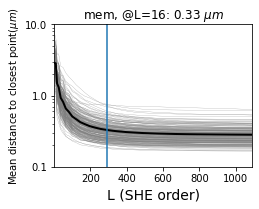

CellId                 distance          
            mean            std      mean       std
lrec                                               
1     610506.795  233587.048419  1.139185  0.459092
2     610506.795  233587.048419  1.135815  0.457804
3     610506.795  233587.048419  0.377573  0.162148
4     610506.795  233587.048419  0.319529  0.163499
5     610506.795  233587.048419  0.197686  0.066622
6     610506.795  233587.048419  0.172524  0.058759
7     610506.795  233587.048419  0.149653  0.038641
8     610506.795  233587.048419  0.140852  0.033367
9     610506.795  233587.048419  0.134482  0.029490
10    610506.795  233587.048419  0.131080  0.027672
11    610506.795  233587.048419  0.128351  0.026370
12    610506.795  233587.048419  0.126724  0.025605
13    610506.795  233587.048419  0.125231  0.024749
14    610506.795  233587.048419  0.124268  0.024372
15    610506.795  233587.048419  0.123408  0.023817
16    610506.795  233587.048419  0.122814  0.023541
17    610506.795  233587.048419  0.122261  0.023127
18    610506.795  233587.048419  0.121872  0.022876
19    610506.795  233587.048419  0.121531  0.022622
20    610506.795  233587.048419  0.121256  0.022415
21    610506.795  233587.048419  0.121043  0.022286
22    610506.795  233587.048419  0.120849  0.022140
23    610506.795  233587.048419  0.120699  0.022050
24    610506.795  233587.048419  0.120553  0.021949
25    610506.795  233587.048419  0.120426  0.021858
26    610506.795  233587.048419  0.120316  0.021777
27    610506.795  233587.048419  0.120214  0.021688
28    610506.795  233587.048419  0.120123  0.021616
29    610506.795  233587.048419  0.120046  0.021545
30    610506.795  233587.048419  0.119978  0.021488
31    610506.795  233587.048419  0.119916  0.021431
32    610506.795  233587.048419  0.119865  0.021390

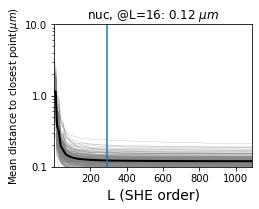

In [81]:
%matplotlib inline
for name, df_str in df_sh.groupby('channel'):
    fig, ax = plt.subplots(1,1,figsize=(3.7,3))
    for _, df_cell in df_str.groupby('CellId'):
        x = (df_cell.lrec+1)**2
        ax.plot(x,df_cell.distance,'-', color='gray', linewidth=0.2)
    df_agg = df_str.groupby('lrec').agg(['mean','std'])
    display(df_agg)
    x = (df_agg.index+1)**2
    ax.plot(x,df_agg[('distance','mean')],'-', color='k', linewidth=2)
    ax.set_yscale('log')
    ax.axvline(x=289)
    ax.set_xlim(1,33**2)
    ax.set_ylim(0.1,10.0)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_title(f"{name}, @L=16: {df_agg.at[16,('distance','mean')]:.2f} $\mu m$")
    ax.set_xlabel('L (SHE order)', fontsize=14)
    ax.set_ylabel('Mean distance to closest point($\mu m$)')
    plt.tight_layout()
    plt.savefig(f'{out}/sherror_{name}.svg', format='svg')
    plt.show()

In [66]:
_, qq = shtools.get_reconstruction_from_coeffs(coeffs, lrec=16)
qq.shape

(66, 132)

In [73]:
10*10

100

In [33]:
out

'/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/local_staging/notebooks/fig_shapespace'